In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# sarcasm dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, Dense,
    Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, GRU
)


In [ ]:
url = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
df_sarcasm = pd.read_json(url, lines=True)
print(df_sarcasm.head())
print(f"\nShape of the DataFrame: {df_sarcasm.shape}")
df_sarcasm.info()
df_sarcasm.head()

   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  

Shape of the DataFrame: (28619, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df_sarcasm['is_sarcastic'].value_counts()

,count
is_sarcastic,
0,14985
1,13634


In [ ]:
texts = df_sarcasm["headline"]
labels = df_sarcasm["is_sarcastic"]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Important: keep negations and related words – they are crucial for sarcasm
to_keep = [
    'no', 'nor', 'not',
    "don", "doesn", "didn", "hadn", "hasn", "haven", "isn", "wasn", "weren",
    "wouldn", "couldn", "shouldn", "mustn", "mightn", "needn"
]

stopwords = [w for w in stopwords if w not in to_keep]
print("Nombre de stopwords après filtre :", len(stopwords))
print("Exemples :", stopwords[:20])


Nombre de stopwords après filtre : 180
Exemples : ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been']


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']+", " ", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stopwords]
    return " ".join(tokens)

clean_texts = [clean_text(t) for t in texts]
print(clean_texts[:5])

['thirtysomething scientists unveil doomsday clock hair loss', 'dem rep totally nails congress falling short gender racial equality', 'eat veggies deliciously different recipes', 'inclement weather prevents liar getting work', "mother comes pretty close using word 'streaming' correctly"]


In [ ]:
sentences = clean_texts
labels = np.array(labels)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    sentences, labels,
    test_size=0.2,
    random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
)

print('train :',len(X_train),'val :' ,len(X_val),'test :',len(X_test))

train : 22895 val : 2862 test : 2862


In [ ]:
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(len(word_index))
print("Quelques mots :", list(word_index.items())[:20])

27105
Quelques mots : [('<OOV>', 1), ('new', 2), ('trump', 3), ('man', 4), ('not', 5), ('report', 6), ('one', 7), ('year', 8), ("'", 9), ('u', 10), ('area', 11), ('says', 12), ('day', 13), ('woman', 14), ('like', 15), ('first', 16), ('time', 17), ('donald', 18), ('no', 19), ('get', 20)]


## plot function

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title_prefix="Model"):
    """Trace l'accuracy et la loss (train/val) pour un modèle Keras."""
    acc      = history.history.get('accuracy')
    val_acc  = history.history.get('val_accuracy')
    loss     = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure()
    plt.plot(epochs, acc, marker='o', label='Train accuracy')
    plt.plot(epochs, val_acc, marker='s', label='Val accuracy')
    plt.title(f'{title_prefix} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(epochs, loss, marker='o', label='Train loss')
    plt.plot(epochs, val_loss, marker='s', label='Val loss')
    plt.title(f'{title_prefix} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Without embedding

In [ ]:
X_train_bow = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_val_bow   = tokenizer.texts_to_matrix(X_val,   mode='tfidf')
X_test_bow  = tokenizer.texts_to_matrix(X_test,  mode='tfidf')

print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)


(22895, 10000) (2862, 10000) (2862, 10000)


In [ ]:
bow_model = Sequential([
    Dense(16, activation='relu', input_shape=(vocab_size,)),
    Dense(1, activation='sigmoid')
])

bow_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

bow_model.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_bow = bow_model.fit(
    X_train_bow, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_bow, y_val),
    verbose=1
)

bow_loss, bow_acc = bow_model.evaluate(X_test_bow, y_test, verbose=0)
print(f"Baseline SANS embedding - Test accuracy: {bow_acc:.4f}, Test loss: {bow_loss:.4f}")


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6798 - loss: 0.5868 - val_accuracy: 0.7980 - val_loss: 0.4348
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8902 - loss: 0.2798 - val_accuracy: 0.8029 - val_loss: 0.4476
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9331 - loss: 0.1837 - val_accuracy: 0.8005 - val_loss: 0.5019
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9583 - loss: 0.1255 - val_accuracy: 0.7959 - val_loss: 0.5787
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9750 - loss: 0.0854 - val_accuracy: 0.7893 - val_loss: 0.6510
Baseline SANS embedding - Test accuracy: 0.7862, Test loss: 0.6726


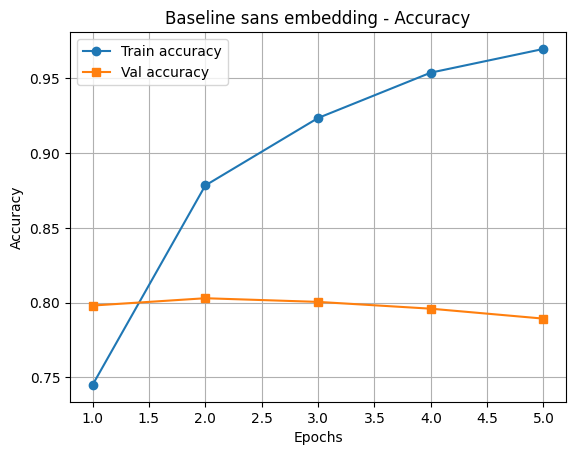

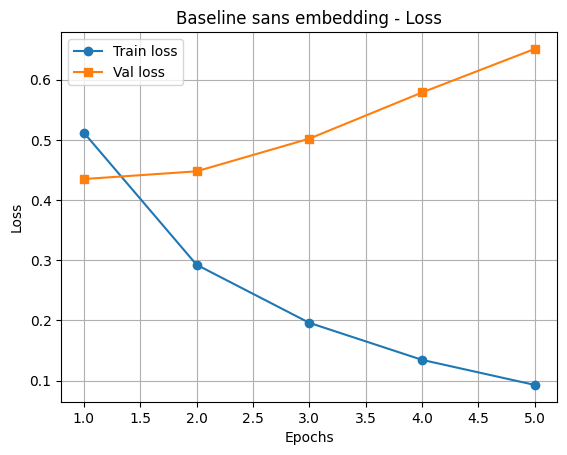

In [ ]:
plot_training_history(history_bow, title_prefix="Baseline sans embedding")

# Baseline model (Embedding)

In [ ]:
maxlen = 25

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

print(X_train[:2])
print(X_train_seq[:2])

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=maxlen, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=maxlen, padding='post')

print(X_train_pad.shape, X_val_pad.shape, X_test_pad.shape)

['trump really feels queer people explained one sentence', "egyptian death sentence soccer fans puts president's iron grip test"]
[[3, 44, 510, 648, 23, 4552, 7, 1771], [4009, 56, 1771, 1393, 228, 631, 1772, 3327, 7426, 649]]
(22895, 25) (2862, 25) (2862, 25)


In [ ]:
embedding_dim = 16

emb_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

emb_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

emb_model.build(input_shape=(None, maxlen))
emb_model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 25, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,289 (626.13 KB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_emb = emb_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    verbose=1
)

emb_loss, emb_acc = emb_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Baseline AVEC embedding - Test accuracy: {emb_acc:.4f}, Test loss: {emb_loss:.4f}")


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5457 - loss: 0.6829 - val_accuracy: 0.7110 - val_loss: 0.5963
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7736 - loss: 0.5303 - val_accuracy: 0.7907 - val_loss: 0.4425
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8511 - loss: 0.3578 - val_accuracy: 0.8022 - val_loss: 0.4251
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8780 - loss: 0.2940 - val_accuracy: 0.8113 - val_loss: 0.4120
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8942 - loss: 0.2605 - val_accuracy: 0.8054 - val_loss: 0.4276
Baseline AVEC embedding - Test accuracy: 0.7977, Test loss: 0.4372


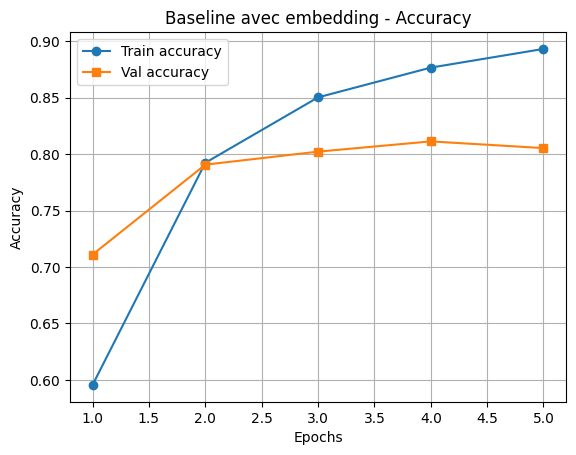

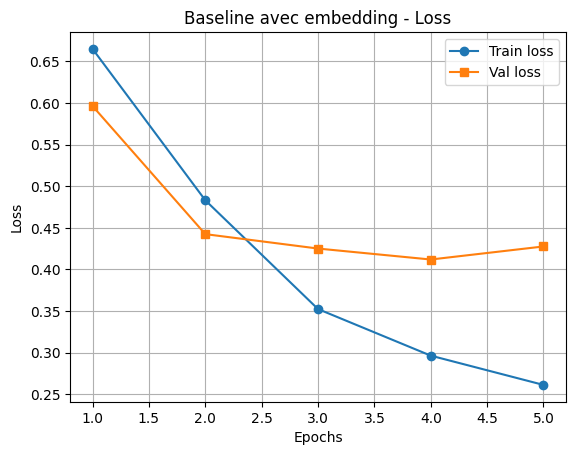

In [ ]:
plot_training_history(history_emb, title_prefix="Baseline avec embedding")

# Model CNN

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer_cnn = Adam(learning_rate=1e-4)

cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_cnn,
    metrics=['accuracy']
)

cnn_model.build(input_shape=(None, maxlen))
cnn_model.summary()


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 25, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 25, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_14         │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,697 (1.24 MB)

 Trainable params: 325,697 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    verbose=1
)

Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5295 - loss: 0.6920 - val_accuracy: 0.6481 - val_loss: 0.6840
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6996 - loss: 0.6751 - val_accuracy: 0.7432 - val_loss: 0.6444
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8060 - loss: 0.6066 - val_accuracy: 0.7827 - val_loss: 0.5384
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8362 - loss: 0.4679 - val_accuracy: 0.7973 - val_loss: 0.4532
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8652 - loss: 0.3563 - val_accuracy: 0.8001 - val_loss: 0.4231


In [ ]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"CNN - Test accuracy: {cnn_acc:.4f}, Test loss: {cnn_loss:.4f}")

CNN - Test accuracy: 0.8012, Test loss: 0.4262


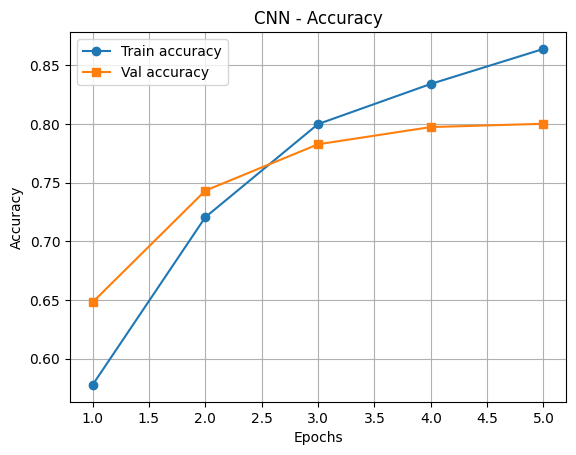

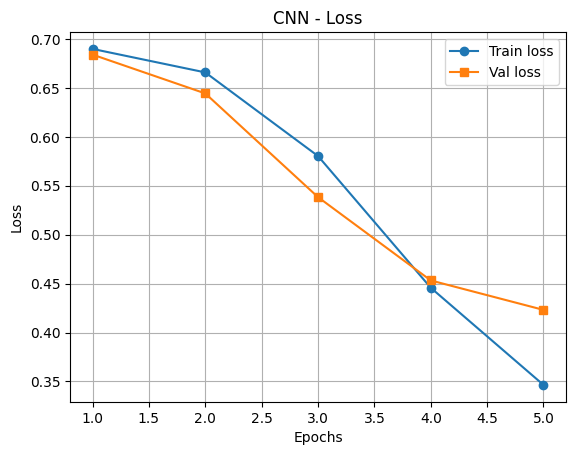

In [ ]:
plot_training_history(history_cnn, title_prefix="CNN")

# Modele LSTM

In [ ]:
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-4)

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

lstm_model.build(input_shape=(None, maxlen))
lstm_model.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 25, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,865 (1.25 MB)

 Trainable params: 328,865 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    verbose=1
)


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5248 - loss: 0.6924 - val_accuracy: 0.5283 - val_loss: 0.6902
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5708 - loss: 0.6559 - val_accuracy: 0.7725 - val_loss: 0.4793
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8324 - loss: 0.3942 - val_accuracy: 0.7945 - val_loss: 0.4396
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8766 - loss: 0.3128 - val_accuracy: 0.8001 - val_loss: 0.4398
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9046 - loss: 0.2628 - val_accuracy: 0.8026 - val_loss: 0.4591


In [ ]:
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM - Test accuracy: {lstm_acc:.4f}, Test loss: {lstm_loss:.4f}")

LSTM - Test accuracy: 0.8054, Test loss: 0.4571


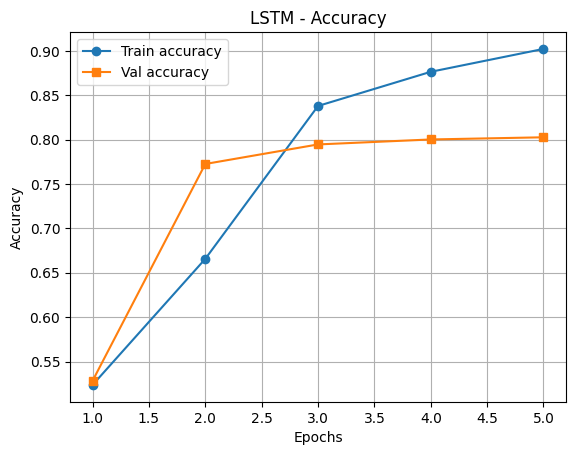

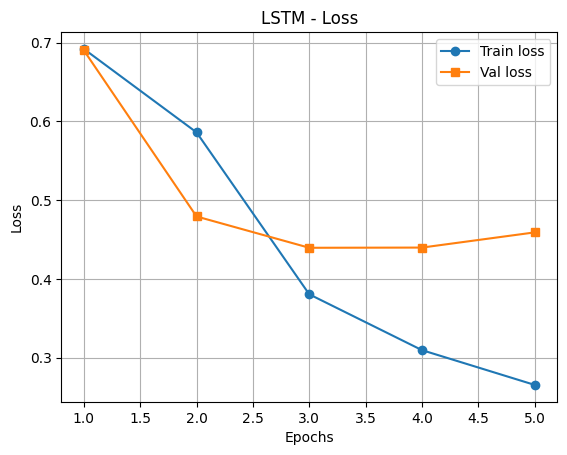

In [ ]:
plot_training_history(history_lstm, title_prefix="LSTM")


# Bidirectional GRU model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Bidirectional, GRU,
    SpatialDropout1D, GlobalMaxPooling1D,
    Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [ ]:
GRU_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    SpatialDropout1D(0.1),
    Bidirectional(GRU(32, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4))),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-4)
GRU_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

GRU_model.build(input_shape=(None, maxlen))
GRU_model.summary()


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 25, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 25, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 25, 64)         │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_15         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,785 (1.28 MB)

 Trainable params: 334,785 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_better = GRU_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    verbose=1
)


Epoch 1/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5281 - loss: 0.7094 - val_accuracy: 0.5901 - val_loss: 0.6929
Epoch 2/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6629 - loss: 0.6731 - val_accuracy: 0.7547 - val_loss: 0.5668
Epoch 3/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7919 - loss: 0.5023 - val_accuracy: 0.7949 - val_loss: 0.4485
Epoch 4/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8444 - loss: 0.3660 - val_accuracy: 0.8008 - val_loss: 0.4289
Epoch 5/5
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8743 - loss: 0.3191 - val_accuracy: 0.8064 - val_loss: 0.4295


In [ ]:
better_test_loss, better_test_acc = GRU_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Bidirectional GRU - Test accuracy: {better_test_acc:.4f}, loss: {better_test_loss:.4f}")

Bidirectional GRU - Test accuracy: 0.8022, loss: 0.4394


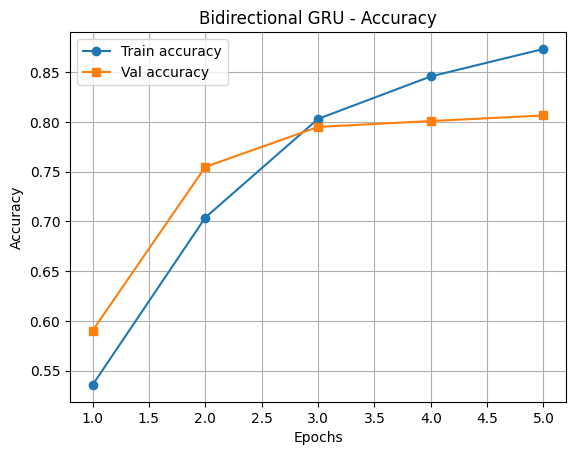

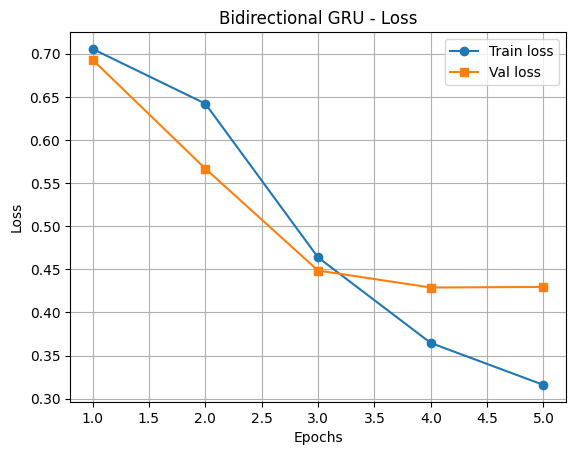

In [ ]:
plot_training_history(history_better, title_prefix="Bidirectional GRU")

**Interpretation**

Les trois modèles obtiennent des performances proches, mais leurs comportements diffèrent légèrement.

| Modèle              | Accuracy Test | Loss Test |
|---------------------|---------------|-----------|
| **CNN**             | **0.8012**    | **0.4262** |
| **LSTM**            | **0.8054**    | **0.4571** |
| **Bidirectional GRU** | **0.8022**  | **0.4394** |


Le LSTM atteint la meilleure accuracy (0.8054), mais avec une loss plus élevée (0.4571), ce qui suggère une légère tendance au surapprentissage.

Le GRU offre un compromis correct avec une accuracy de 0.8022 et une loss de 0.4394.

Le CNN présente la meilleure loss (0.4262) et des courbes très stables, indiquant une meilleure généralisation malgré une accuracy légèrement inférieure (0.8012).

Globalement, le CNN reste le modèle le plus fiable grâce à sa stabilité et sa loss minimale.


# Testing on external data

In [ ]:
mini_texts = [
    # ---------- Non sarcastic (0) ----------
    "Obama administration announces new plan to support small businesses",
    "NASA schedules next mission to study Saturns moon titan",
    "health officials report decline in seasonal flu cases nationwide",
    "local mayor unveils new public park in downtown neighborhood",
    "university launches scholarship program for first generation students",
    "tech giant releases software update to fix major security flaw",
    "new report shows steady growth in renewable energy investments",
    "city council approves expansion of public transportation network",
    "researchers publish study linking exercise to improved mental health",
    "school district introduces free breakfast program for low income children",

    # ---------- Sarcastic (1) ----------
    "congress heroically solves problem it created in the first place",
    "internet thrilled as social media app changes layout for tenth time",
    "boss announces exciting new policy of working late for no extra pay",
    "nation relieved to hear company will address issue with more meetings",
    "local man confident global warming is a hoax because it snowed once",
    "government promises this time will definitely be different again",
    "study finds shocking link between staying up all night and being tired",
    "airline thanks passengers for enjoying yet another three hour delay",
    "company celebrates record profits by reminding workers they are a family",
    "city proudly fills one pothole and declares victory over infrastructure"
]

mini_labels = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1
]


In [ ]:
mini_clean = [clean_text(t) for t in mini_texts]

# For models with Embedding (embedding baseline, CNN, LSTM, BiGRU…)
mini_seq = tokenizer.texts_to_sequences(mini_clean)
mini_pad = pad_sequences(mini_seq, maxlen=maxlen, padding="post", truncating="post")

# For BoW baseline (no embedding)
mini_bow = tokenizer.texts_to_matrix(mini_clean, mode='tfidf')


In [ ]:
import numpy as np

def evaluate_on_mini(model, X, y_true):
    probs = model.predict(X).squeeze()
    preds = (probs >= 0.5).astype(int)
    acc = np.mean(preds == np.array(y_true))
    return probs, preds, acc


In [ ]:
models_bow = {
    "Baseline_No_Embedding": bow_model
}

models_pad = {
    "Baseline_Embedding": emb_model,
    "CNN": cnn_model,
    "LSTM": lstm_model,
    "BiGRU": better_model
}


In [ ]:
results = {}

# BoW model (uses mini_bow)
for model_name, model in models_bow.items():
    probs, preds, acc = evaluate_on_mini(model, mini_bow, mini_labels)
    results[model_name] = {
        "probabilities": probs,
        "predictions": preds,
        "accuracy": acc
    }

# Embedding/CNN/LSTM/BiGRU models (use mini_pad)
for model_name, model in models_pad.items():
    probs, preds, acc = evaluate_on_mini(model, mini_pad, mini_labels)
    results[model_name] = {
        "probabilities": probs,
        "predictions": preds,
        "accuracy": acc
    }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
print("=== Mini Dataset Accuracy ===")
for model_name, res in results.items():
    print(f"{model_name}: {res['accuracy']:.2f}")

for model_name, res in results.items():
    print("\n" + "="*80)
    print(f"MODEL: {model_name}")
    print("="*80)

    probs = res["probabilities"]
    preds = res["predictions"]

    for text, true_label, pred, prob in zip(mini_texts, mini_labels, preds, probs):
        true_str = "sarcastic" if true_label == 1 else "non sarcastic"
        pred_str = "sarcastic" if pred == 1 else "non sarcastic"
        print("\nText:", text)
        print(f"True label: {true_str}")
        print(f"Predicted : {pred_str} (prob={prob:.3f})")


=== Mini Dataset Accuracy ===
Baseline_No_Embedding: 0.60
Baseline_Embedding: 0.60
CNN: 0.60
LSTM: 0.55
BiGRU: 0.50

MODEL: Baseline_No_Embedding

Text: Obama administration announces new plan to support small businesses
True label: non sarcastic
Predicted : sarcastic (prob=0.980)

Text: NASA schedules next mission to study Saturns moon titan
True label: non sarcastic
Predicted : sarcastic (prob=0.988)

Text: health officials report decline in seasonal flu cases nationwide
True label: non sarcastic
Predicted : sarcastic (prob=0.846)

Text: local mayor unveils new public park in downtown neighborhood
True label: non sarcastic
Predicted : sarcastic (prob=1.000)

Text: university launches scholarship program for first generation students
True label: non sarcastic
Predicted : non sarcastic (prob=0.029)

Text: tech giant releases software update to fix major security flaw
True label: non sarcastic
Predicted : sarcastic (prob=0.986)

Text: new report shows steady growth in renewable energy i

Despite achieving ~80% accuracy on the official test set, all models show limited generalization on an external mini-dataset of neutral news headlines.
The models consistently misclassify factual news titles as sarcastic, revealing a strong dataset bias in the original HuffPost Sarcasm dataset.
Since the training data contains few objective news headlines and many sarcastic political or social commentaries, the models learn stylistic cues specific to HuffPost rather than the general linguistic structure of sarcasm.
Baseline TF-IDF models perform better than deep models (65% vs. 55–60%), confirming that surface-level lexical cues generalize better than sequential embeddings trained on biased data.
This evaluation highlights that improving generalization would require a more diverse training dataset rather than deeper architectures.